# Anomaly detection

In this chapter we will dimensionality reduction algorithm for the task on anomaly detection. We will develop an anomaly detection solution for the task of capturing fraud in a credit card transaction dataset.

When we use supervised learning to solve this problem, we rely upon provided labels that allow the learning algorithm to distinguish between the geniune and fraudulent transactions. With time, however, fraud patterns change and the algorithm has to be constantly retrained to capture new fraud trends. For this reason, using a non-supervised learning algorithm for fraud detection is very popular.


### Prepare the data

The credit card dataset contains 284804 transactions, of which 492 are fraudulent. We will not use labels to train the algorithm, instead, we will evaluate algorithm using known labels. We split the dataset into a training and a test set using a balanced split.

In [2]:
# Required imports
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [23]:
# Load datasets
current_path = os.getcwd()
file = '\\datasets\\credit_card_data\\credit_card.csv'
data = pd.read_csv(current_path + file)

dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                    random_state=2018, stratify=dataY)

### Define Anomaly Score Function

Using anomaly detection to capture fraud means that we consider fraudulent transaction to be anomalies. That is, the more anomalous the transaction is, the more likely it is fraudulent.

Dimensionality reduction algorithms reduce dimensions of the data while trying to minimize the reconstruction error. They identify the most salient features and keep them while discarding the less important features. We can expect that anomalous entries will suffer the most when the data is reconstructed. This means, we can use the reconstruction error as the score function for the anomaly detection.

The reconstuction error is the sum of the queared differences between the original feature matrix and the  matrix reconstracted by a dimensionality reduction algorithm. We will scale the sum of squared differences by the max-min range of the sum of the squared differences for the entire dataset, so that the reconstruction error is in range between 0 and 1.

The scroing function is then:

In [24]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

### Define Evaluation 

As mentioned before, we will not use the available labels for the training. Instead we will use them for the evaluation. The metrics we will employ are the __precision-recall curve__, the __average precision__, and the __auROC__.

To plot the results, we will use this function:

In [25]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

### Note on the metrics

These metrics will helpus to asses how good the unsupervised frau detection systems are at catching __known__ pattern of fraud - fraud that we have caught in the past and have labels for.

We will not be able to assess how good the unsupervised learning systems are at catching __unknown__ patterns of fraud. In other words, the current dataset may have transactions that are fraudulent but have never been discovered and are not labeled as fraud.

Unfortunately, we cannot go to the financial company and ask them to evaluate new instances of fraud our unsupervised system might find. This shows, how difficult it really is to evaluate unsupervised systems by using only already known patterns.

### Define Plotting Function

This function will generate a scatter plot to display the separation of points, the dimensionality reduction algorithms achieves in just two dimensions.

In [26]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

## Normal PCA Anomaly Detection

We have seen, how powerful PCA can be when applied on the MNIST handwritten digits dataset. It made it possible to visually separate digits by using only two dimensions.

Now, we will let PCA learn the underlying structure of the credit card transactions dataset. We remember that the availbale dataset has alredy been processed by a PCA algorithm. However, it is not unusual to perform a PCA on alredy dimensionally-reduced dataset.

When designing an anomaly detection system using a dimensionality-reduction algorithm, we must keep in mind that the goals it to have the highest reconstruction error for dataset entries that are anomalous, i.e. fraudulent. The geniune transactions have to have the reconstruction error as low as possible.

For PCA the reconstruction error depends on how many dimensions we are going gto keep. The lowest error will be when all dimensions are kept. But in this case, me may not be able to distinguish fraud. If we keep to few dimensions, the PCA might not be able to reconstruct the dataset well enough and again the hight reconstruction error across the entire dataset will not allow us to see what transactions are fraudulent. We will have to find an optimum number of dimensions.

To demonstrate this point, we first try to apply PCA while keeping all 30 features.

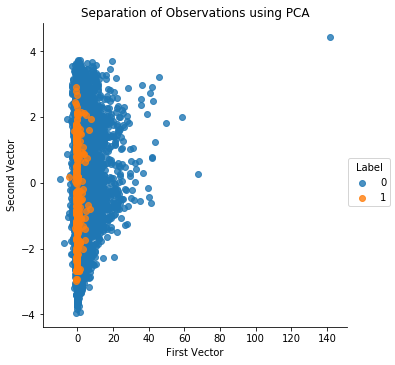

In [27]:
# 30 principal components
from sklearn.decomposition import PCA

n_components = 30
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

Now, let's calculate the precision-recall curve and ROC:

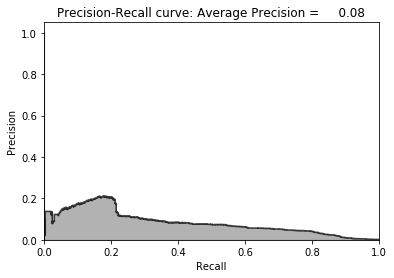

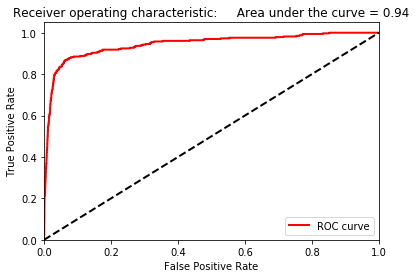

In [28]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

With an average precision of 0.08 this is a very poor solution for fraud detection. 

### Search for the Optimal Number of Principal Components

Let's reduce the number of principal components and evaluate the results. We do not the situation when the error is to low or too high so that the rare and the normal transaction are indistinguishable.

We can experiment with different numbers of principal components. It appears that 27 perform the best:

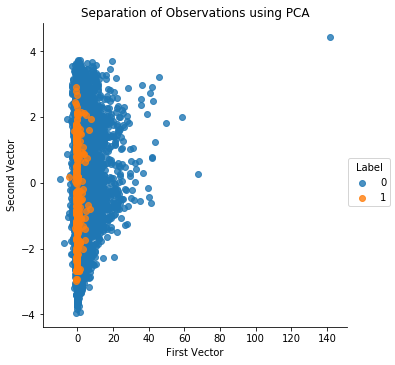

In [29]:
# 27 principal components
from sklearn.decomposition import PCA

n_components = 27
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

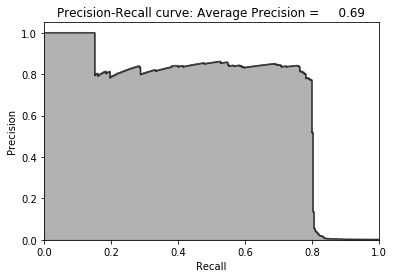

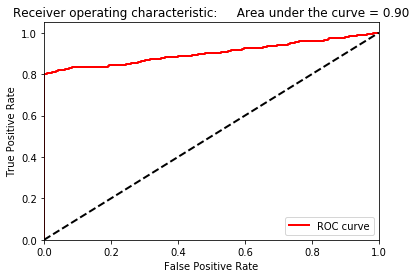

In [30]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

We can see that the system can catch 80% of fraud with 75% precision. Given that we did not use any labels, this is impressive. Particularly when we recall that we have inspected 190820 transactions of which only 330 are fraudulent.

The PCA gives us the reconstruction error for each of these 190820 transactions. If we sort the transaction by their reconstruction error (anomaly scrore) in descending order and cut 350 topmost, we will be able to see that 264 of them are actually fraudulent.

This is the precision of 75%. The 264 caught transaction represent 80% of the true 350 fraudulent entries. This is 80% recall.

This is the code that does this:

In [32]:
preds.sort_values(by="anomalyScore", ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ", np.round(
    predsTop.anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))

print("Recall: ", np.round(
    predsTop.anomalyScore[predsTop.trueLabel==1].count() \
    / y_train.sum(), 2))
print("Fraud Caught out of 350 Cases: ", predsTop.trueLabel.sum())


Precision:  0.75
Recall:  0.8
Fraud Caught out of 350 Cases:  264


## Sparse PCA Anomaly Detection

Recall that Sparse PCA delivers a less dense solution than the normal PCA. We will need to spesify the number of components and the parameter __alpha__ that controls the degree of sparsity. We will have to experiment with different values of these two parameters for the optimal result.

The normal PCA has the  `inverse_transform` function that reconstructs the dataset. The Sparse PCA does not have it, so we will have to implement it ourselves.

Let's begin the Sparse PCA with 27 principal components and the default aplpha value of 0.0001:

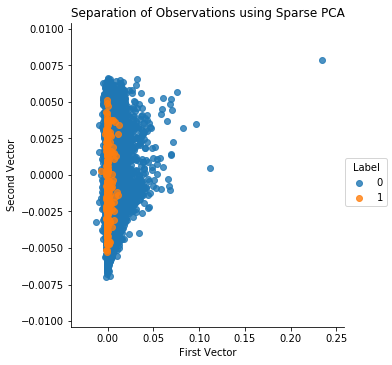

In [33]:
from sklearn.decomposition import SparsePCA

n_components = 27
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, \
                     alpha=alpha, random_state=random_state, \
                     n_jobs=n_jobs)

sparsePCA.fit(X_train.loc[:,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA,
                                index=X_train.index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")



Below you will see the code that reconstructs the reduced dataset to the original features by matrix multiplication: the sparse PCA matrix ($190820 \times 27$) and the sparse PCA components ($27 \times 30$). We  then add to thre restored features their respective mean.

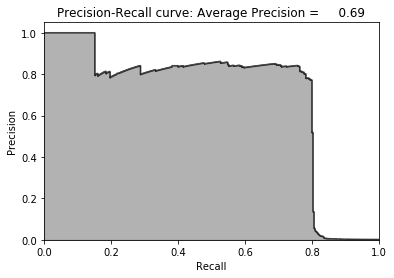

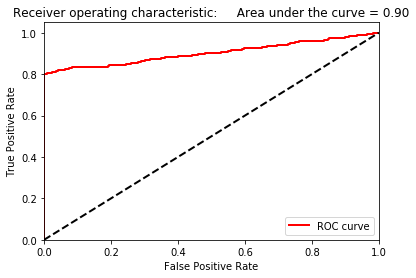

In [34]:
X_train_sparsePCA_inverse = \
np.array(X_train_sparsePCA).dot(sparsePCA.components_) \
+ np.array(X_train.mean(axis=0))

X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=X_train.index)

anomalyScoresSparsePCA = anomalyScores(X_train, X_train_sparsePCA_inverse)
preds = plotResults(y_train, anomalyScoresSparsePCA, True)

The results are identical to those of the normal PCA. This is expected because normal and sparse PCA are very similar - the latter is just a sparse representation of the former.

## Kernel PCA Anomaly Detection

We can use a non-linear dimensionality reduction with kernel PCA. This can be useful if the fraudulent cases are not linearly separable from the geniune ones.

We will need to specify the number of components, the kernel (in our case, 'rbf'), and the gamma (which is set to $1/n_features$ by default, or, in our case, 1/30). We will need to set `fit_inverse_transform` to `true` to apply the built-in inverse transform function.

Kernel PCA is expensive to train, so wi will train on just the first 200 samples.

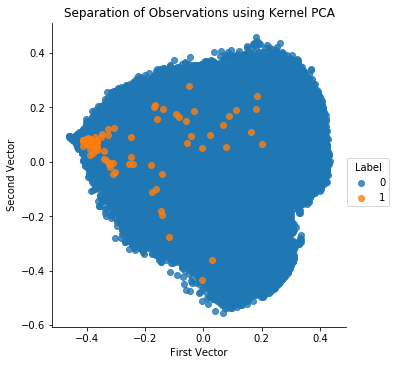

In [36]:
# Kernel PCA
from sklearn.decomposition import KernelPCA

n_components = 27
kernel = 'rbf'
gamma = None
fit_inverse_transform = True
random_state = 2018
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, \
                gamma=gamma, fit_inverse_transform= \
                fit_inverse_transform, n_jobs=n_jobs, \
                random_state=random_state)

kernelPCA.fit(X_train.iloc[:200])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA, \
                                 index=X_train.index)

X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse, \
                                         index=X_train.index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

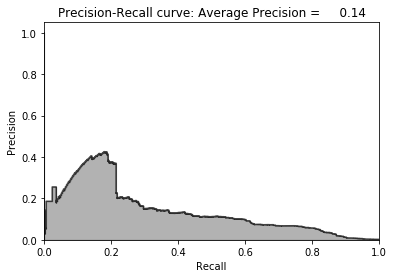

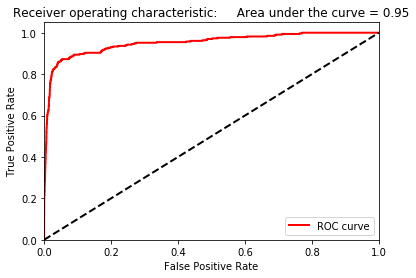

In [37]:
anomalyScoresKernelPCA = anomalyScores(X_train, X_train_kernelPCA_inverse)
preds = plotResults(y_train, anomalyScoresKernelPCA, True)

As we can see, the results provided by kernel PCA are far worse than those from normal and sparse PCA. It is useful to experiment with different algorithms, but we will not use kernel PCA for the final fraud detection solution.

## Gaussian Random Projection Anomaly Detection

Now, let's try to implement anomaly detection with Gaussian random projection. Here, we will have to either set the desired number of compoments or use the _eps_ parameter that control the quality of the embedding.

For now, we choose to set the number of components explicitly. Gaussian random projections train quickly, so we can train on the entire training set.

As with sparse PCA, we will have to derive our own inverse transformation function.

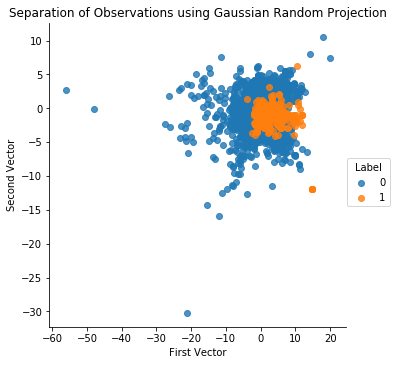

In [38]:
# Gaussian Random Projection
from sklearn.random_projection import GaussianRandomProjection

n_components = 27
eps = None
random_state = 2018

GRP = GaussianRandomProjection(n_components=n_components, \
                               eps=eps, random_state=random_state)

X_train_GRP = GRP.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=X_train.index)

scatterPlot(X_train_GRP, y_train, "Gaussian Random Projection")

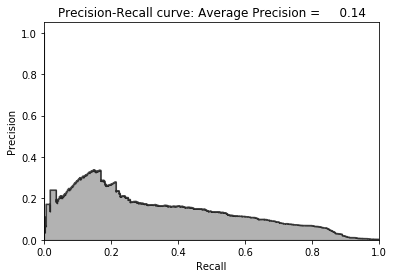

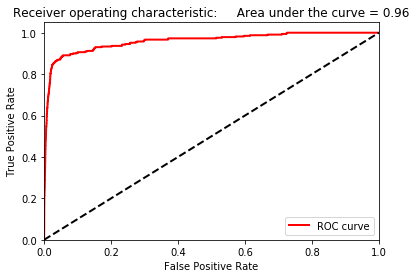

In [39]:
X_train_GRP_inverse = np.array(X_train_GRP).dot(GRP.components_)
X_train_GRP_inverse = pd.DataFrame(data=X_train_GRP_inverse, \
                                   index=X_train.index)

anomalyScoresGRP = anomalyScores(X_train, X_train_GRP_inverse)
preds = plotResults(y_train, anomalyScoresGRP, True)

These results are not good enough and Gaussian random projection is not a suitable candidate for the final solution.

## Sparse Random Projection Anomaly Detection

Now, let's try sparse random projection for our task. We will set the desired number of parametrs and will have to implement our ouwn inverse transformation.

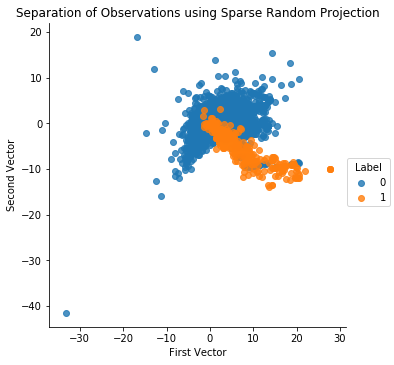

In [40]:
# Sparse Random Projection

from sklearn.random_projection import SparseRandomProjection

n_components = 27
density = 'auto'
eps = .01
dense_output = True
random_state = 2018

SRP = SparseRandomProjection(n_components=n_components, \
        density=density, eps=eps, dense_output=dense_output, \
                                random_state=random_state)

X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=X_train.index)

scatterPlot(X_train_SRP, y_train, "Sparse Random Projection")

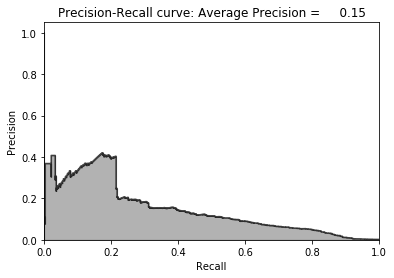

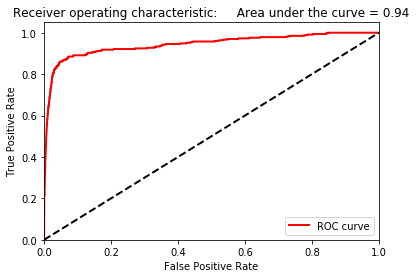

In [41]:
X_train_SRP_inverse = np.array(X_train_SRP).dot(SRP.components_.todense())
X_train_SRP_inverse = pd.DataFrame(data=X_train_SRP_inverse, index=X_train.index)

anomalyScoresSRP = anomalyScores(X_train, X_train_SRP_inverse)
plotResults(y_train, anomalyScoresSRP)

Another set of poor results. We turn sparse random projection down.

## Nonlinear Anomaly Detection

Until now we have tries several methods based on linear dimensionality reduction: normal PCA, sparse PCA, Gaussian random projection and sparse random projection. We also tried a non-linear method: kernel PCA. Out of those the best results were given by PCA.

The non-linear (manifold learning) methods available as open-source run very slowly, so we will have to skip them and try the non-distance methods.

## Dictionary Learning Anomaly Detection

Recall that with dictionary learning the algorithm creates a sparse representation of the original data in a form of atom vectors in a dictionary. We can use these atom vectors to reconstruct the original dataset.

For the dimensionality reduction we need to learn an undercomplete dictionary. In our case, we will generate 28 vectors. We weill feed the learning algorithm in 10 batches each consisting of 200 samples.

We will have to use our own inverse transformation function.

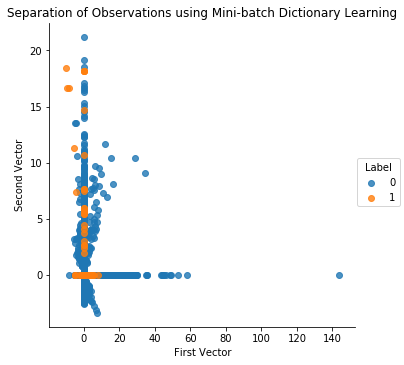

In [42]:
# Mini-batch dictionary learning
from sklearn.decomposition import MiniBatchDictionaryLearning

n_components = 28
alpha = 1
batch_size = 200
n_iter = 10
random_state = 2018

miniBatchDictLearning = MiniBatchDictionaryLearning( \
    n_components=n_components, alpha=alpha, batch_size=batch_size, \
    n_iter=n_iter, random_state=random_state)

miniBatchDictLearning.fit(X_train)
X_train_miniBatchDictLearning = \
    miniBatchDictLearning.fit_transform(X_train)
X_train_miniBatchDictLearning = \
    pd.DataFrame(data=X_train_miniBatchDictLearning, index=X_train.index)

scatterPlot(X_train_miniBatchDictLearning, y_train, \
            "Mini-batch Dictionary Learning")

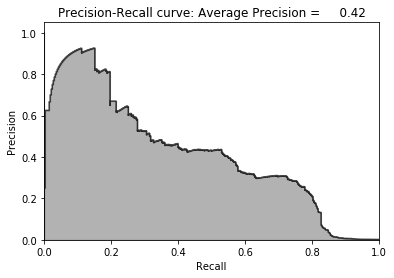

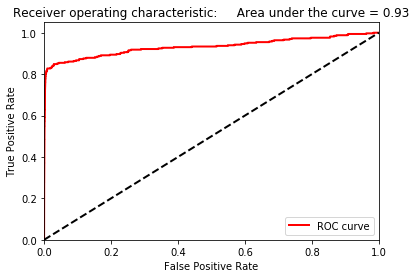

In [43]:
X_train_miniBatchDictLearning_inverse = \
    np.array(X_train_miniBatchDictLearning). \
    dot(miniBatchDictLearning.components_)

X_train_miniBatchDictLearning_inverse = \
    pd.DataFrame(data=X_train_miniBatchDictLearning_inverse, \
                 index=X_train.index)

anomalyScoresMiniBatchDictLearning = anomalyScores(X_train, \
    X_train_miniBatchDictLearning_inverse)
preds = plotResults(y_train, anomalyScoresMiniBatchDictLearning, True)

The results from the dctionary learning are much better than from random projections but still are worse than those of PCA.